In [1]:
import gym
import seagul.envs
import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PPOModel, SwitchedPPOModel, SwitchedPPOModelActHold
from seagul.nn import MLP
#torch.set_default_dtype(torch.double)
dtype = np.float32

import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd
from torch.multiprocessing import Pool
from itertools import product
from seagul.plot import smooth_bounded_curve
import os



/home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


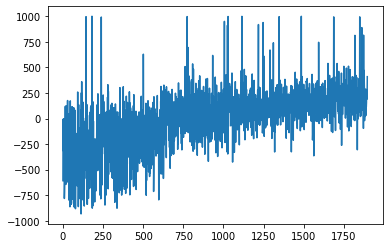

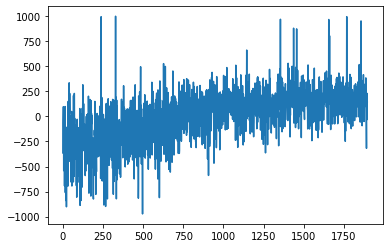

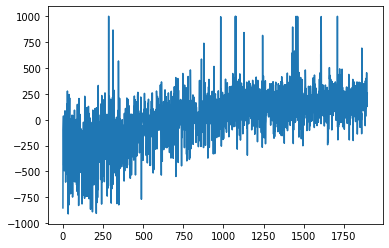

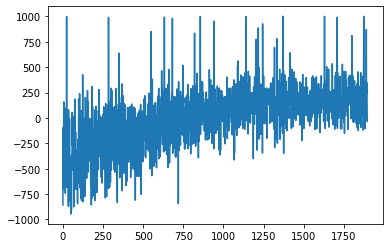

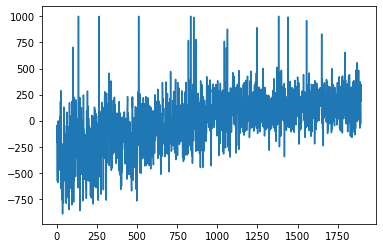

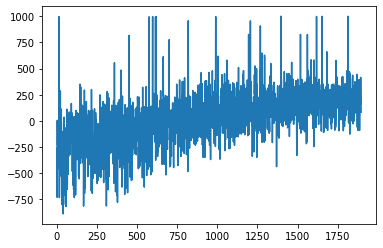

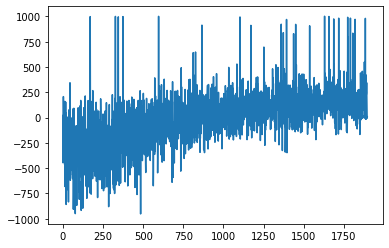

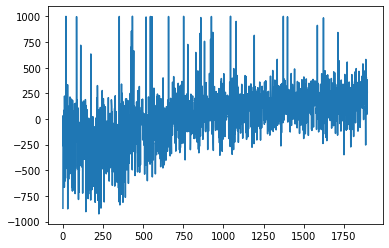

<Figure size 432x288 with 0 Axes>

In [53]:
import os
jup_dir = "/home/sgillen/work/"
directory = jup_dir + \
"seagul/seagul/notebooks/switching/data_needle/1ah_switch_longer"

#"seagul/seagul/notebooks/switching/data5_sac/trialtrial19/"


ws_list = []
model_list = []
for entry in os.scandir(directory):
            model, env, args, ws = load_workspace(entry.path)
            plt.plot(ws["raw_rew_hist"])
            plt.yscale
            
            
            plt.figure()
            ws_list.append(ws)
            model_list.append(model)


(0, 8000)

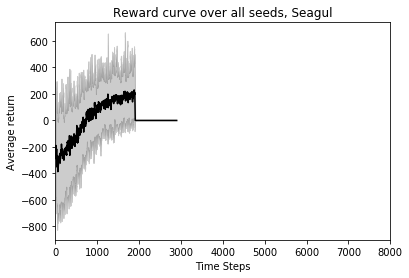

In [55]:
from seagul.plot import smooth_bounded_curve

rewards = np.zeros((len(ws["raw_rew_hist"]) + 1000, len(ws_list)))

for i,ws in enumerate(ws_list):
    #plt.plot(ws["raw_rew_hist"])
    #plt.figure()
    #print(len(ws["raw_rew_hist"]))

    rewards[:len(ws["raw_rew_hist"]),i] = np.array(ws["raw_rew_hist"])
    
fig, ax = smooth_bounded_curve(rewards,window=10)  
ax.set_title('Reward curve over all seeds, Seagul')
ax.set_xlim(0, 8000)
#ws = ws_list[0]
#model = model_list[0]

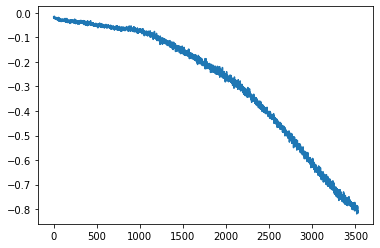

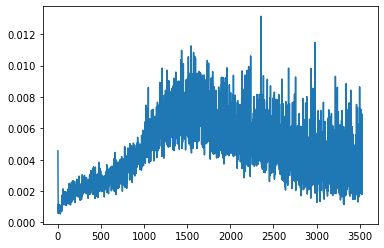

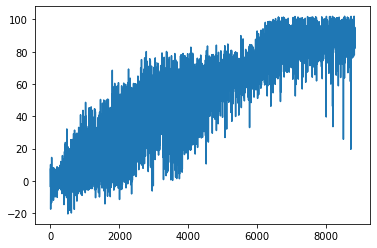

In [10]:
ws=ws_list[-1]
model = model_list[-1]

plt.plot(ws['pol_loss_hist'])
plt.figure()
plt.plot(ws['val_loss_hist'])
plt.figure()
plt.plot(ws['raw_rew_hist'])

In [ ]:
#torch.save(model.value_fn, open('./warm/ppo2_warm_valh2','wb'))
#torch.save(model.policy, open('./warm/ppo2_warm_polh2','wb'))

In [3]:
#model.value_fn.state_dict()

In [34]:
env = gym.make(ws['env_name'], **ws['env_config'])
max_torque = ws['env_config']['max_torque']

def do_rollout(env, model, num_steps):
    acts_list = []
    obs1_list = []
    obs2_list = []
    rews_list = []
    path_list = []
    done_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    obs = env.reset()
    model.thresh = model.thresh_on

    while not done:
        obs1_list.append(obs)
        path = model.sig(model.gate_fn(np.array(obs, dtype=np.float32))) > model.thresh

        if path:
            model.thresh = model.thresh_off
            for _ in range(model.hold_count):
                acts = model.balance_controller(obs).reshape(-1, model.num_acts)
                obs, rew, done, _ = env.step(acts.numpy())
        else:
            model.thresh = model.thresh_on
            acts = model.swingup_controller(obs.reshape(-1, obs_size)).reshape(-1, model.num_acts)
            for _ in range(model.hold_count):
                obs, rew, done, _ = env.step(acts.numpy().reshape(-1))

        if cur_step < num_steps:
            done_list.append(torch.as_tensor(done))
        else:
            done_list.append(torch.as_tensor(False))

        acts_list.append(torch.as_tensor(acts.clone()))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        path_list.append(path.clone())
        obs2_list.append(obs)

        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list, dtype=dtype)
    ep_acts = torch.stack(acts_list).reshape(-1, act_size)
    ep_rews = torch.stack(rews_list).reshape(-1, 1)
    ep_obs2 = torch.tensor(obs2_list, dtype=dtype)
    ep_done = torch.stack(done_list).reshape(-1, 1)
    ep_path = torch.tensor(path_list).reshape(-1,1)

    return ep_obs1, ep_obs2, ep_acts, ep_rews, ep_done, ep_path


def do_rollout(env, model, num_steps):
    acts_list = []
    obs2_list = []
    obs1_list = []
    rews_list = []
    path_list = []
    done_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    obs = env.reset()

    while not done:
       
        obs = torch.as_tensor(obs, dtype=torch.float32)
        acts, val, _, _ = model.step(obs.reshape(-1, obs_size))
        acts = acts.reshape(-1, model.num_acts).detach()
        obs, rew, done, _ = env.step(acts.numpy().reshape(-1))

        acts_list.append(torch.as_tensor(acts.clone()))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        obs1_list.append(obs)

        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list, dtype=dtype)
    ep_acts = torch.stack(acts_list).reshape(-1, act_size)
    ep_rews = torch.stack(rews_list).reshape(-1, 1)
    #ep_obs2 = torch.tensor(obs2_list, dtype=dtype)
    #ep_done = torch.stack(done_list).reshape(-1, 1)
    #ep_path = torch.tensor(path_list).reshape(-1,1)

    return ep_obs1, [], ep_acts, ep_rews, [], []





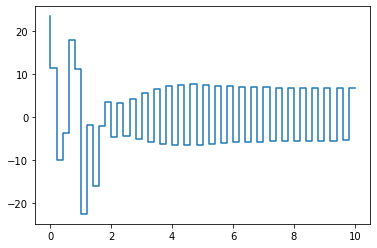

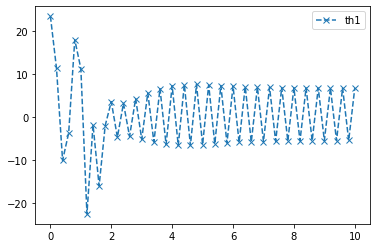

In [40]:
obs1, obs2, acts, rews, done, path = do_rollout(env,model,50)

t = np.array([i*.01*20 for i in range(obs1.shape[0])])

plt.step(t, acts)
plt.figure()
plt.plot(t, acts, 'x--')
plt.legend(['th1', 'th2', 'th1dot', 'th2dot'])



tensor([94.6973])


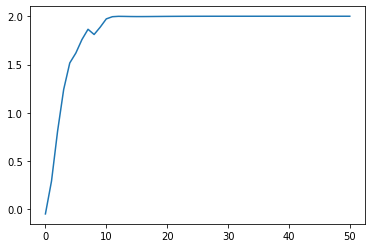

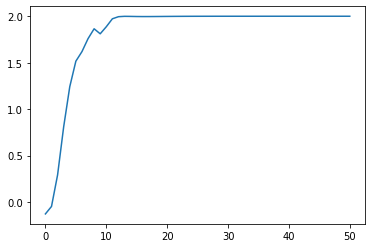

In [10]:
print(sum(rews))
plt.plot(rews)
plt.figure()
plt.plot((np.sin(obs1[:,0]) + np.sin(obs1[:,0] + obs1[:,1])))\

In [11]:
plt.plot(means_hist)
plt.figure()

NameError: name 'means_hist' is not defined

ModuleNotFoundError: No module named 'pydrake'

In [ ]:
from seagul.plot import smooth_bounded_curve

hp_str = "max_torque"
hp_vals = [1,5,25,100]
seeds = [0,1]

num_seeds = 2
num_hp = 4
rewards = np.zeros((len(ws["raw_rew_hist"]), num_seeds, num_hp))

for ws in ws_list:
    hp = hp_vals.index(ws['env_config'][hp_str])
    seed = seeds.index(ws['seed'])
    rewards[:,seed, hp] = np.array(ws["raw_rew_hist"])


fig, axs = plt.subplots(4, 1,sharey =True, figsize=(15,25))

for i,hp in enumerate(hp_vals):
    smooth_bounded_curve(rewards[:,:,i], axs[i])
    
axs[0].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[0]))
axs[1].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[1]))
axs[2].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[2]))
axs[3].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[3]))

In [ ]:
import torch.multiprocessing as multiprocessing
pool = multiprocessing.Pool()

env_name = "su_acroswitch-v0"
def do_rollout(init_point):
    env = gym.make(env_name, **ws['env_config'])
    if init_point is not None:
        obs = env.reset(init_point)
    else:
        obs = env.reset()

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []

    done = False
    
    while not done:
        
        
        #env.lqr_on = True
        obs = torch.as_tensor(obs, dtype=torch.float32)

        actions, _, _, logp = model.step(obs.reshape(1,-1))
        actions = actions.detach()
        #actions, logp = model.select_action(obs)
        obs_hist.append(obs)
    
        #actions = np.clip(actions, -max_torque, max_torque)
        actions = torch.as_tensor(actions, dtype=torch.float32)
        obs, reward, done, _ = env.step(actions.detach().numpy())

        
    #reward_hist = np.stack(reward_hist)
    #print(env.lqr_on)
    obs_hist = np.stack(obs_hist)
    
    return obs_hist, action_hist, reward_hist, env.lqr_on

In [52]:
th1_min = 0; th1_max = 2*pi; num_th1 = 41
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -pi; th2_max = pi; num_th2 = 41
th2_vals = np.linspace(th2_min, th2_max, num_th2)

results = np.zeros((th1_vals.size, th2_vals.size))
lqr_results = np.zeros((th1_vals.size, th2_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size))

end_point = np.array([1.57079633, 0.        , 0.        , 0.        ])

import time
start = time.time()

for i,res in enumerate(pool.imap(do_rollout, product(th1_vals, th2_vals, [0], [0]))):
        obs_hist, action_hist, reward_hist, lqr_on = res
        errs = np.sum(abs(obs_hist[-5:] - end_point) , axis=1) < 1.5 
        results.flat[i] = errs.all()
        lqr_results.flat[i] = lqr_on
        rewards.flat[i] = sum(reward_hist)

       
end = time.time()
print(end - start)

9.83969235420227


Text(0, 0.5, 'th2')

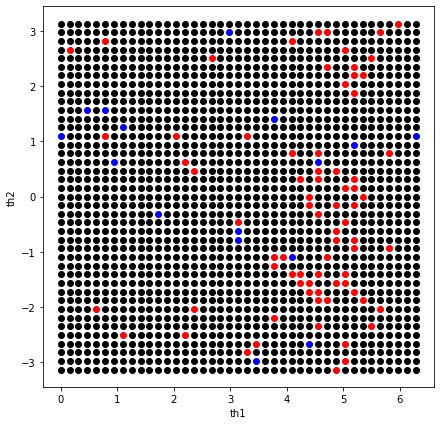

In [53]:
plt.figure(figsize=(7,7))

weird_list = []
for i in range(th1_vals.shape[0]):
    for j in range(th2_vals.shape[0]):
        if lqr_results[i,j] and results[i,j]:
            plt.plot(th1_vals[i], th2_vals[j], 'o', color = 'k', alpha=1)
            
        elif lqr_results[i,i] and not results[i,j]:            
           plt.plot(th1_vals[i], th2_vals[j], 'o', color = 'r', alpha=1)
            
        elif results[i,j] and not lqr_results[i,j]:
           plt.plot(th1_vals[i], th2_vals[j], 'o', color = 'b', alpha=1)
           weird_list.append((i,j))

plt.xlabel('th1')
plt.ylabel('th2') 

In [54]:
dth1_min = -10; dth1_max = 10; num_dth1 = 41
dth1_vals = np.linspace(dth1_min, dth1_max, num_dth1)

dth2_min = -30; dth2_max = 30; num_dth2 = 41
dth2_vals = np.linspace(dth2_min, dth2_max, num_dth2)

results = np.zeros((dth1_vals.size, dth2_vals.size))
lqr_results = np.zeros((dth1_vals.size, dth2_vals.size))
rewards = np.zeros((dth1_vals.size, dth2_vals.size))

end_point = np.array([1.57079633, 0.        , 0.        , 0.        ])

import time
start = time.time()

for i,res in enumerate(pool.imap(do_rollout, product([0],[0] , dth1_vals, dth2_vals))):
        obs_hist, action_hist, reward_hist, lqr_on = res
        errs = np.sum(abs(obs_hist[-5:] - end_point) , axis=1) < 1.5 
        results.flat[i] = errs.all()
        lqr_results.flat[i] = lqr_on
        rewards.flat[i] = sum(reward_hist)

       
end = time.time()
print(end - start)

8.649925231933594


Text(0.5, 0, 'dth1')

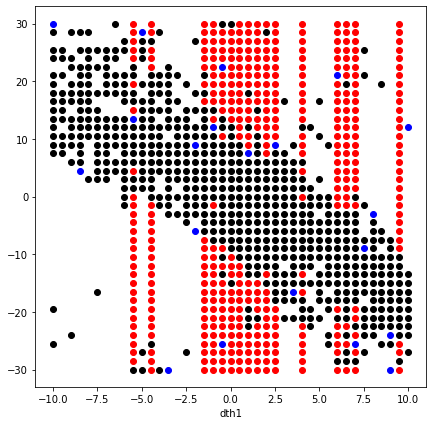

In [55]:
plt.figure(figsize=(7,7))

weird_list = []
for i in range(dth1_vals.shape[0]):
    for j in range(dth2_vals.shape[0]):
        if lqr_results[i,j] and results[i,j]:
            plt.plot(dth1_vals[i], dth2_vals[j], 'o', color = 'k', alpha=1)
            
        elif lqr_results[i,i] and not results[i,j]:            
           plt.plot(dth1_vals[i], dth2_vals[j], 'o', color = 'r', alpha=1)
            
        elif results[i,j] and not lqr_results[i,j]:
           plt.plot(dth1_vals[i], dth2_vals[j], 'o', color = 'b', alpha=1)
           weird_list.append((i,j))

plt.xlabel('dth1')
plt.xlabel('dth1')